### get svg points array from csv

In [20]:
csv_name = "./isolated.csv"

In [21]:
import numpy as np

csv_path = csv_name


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs


paths = read_csv(csv_path)
print(paths)

[[array([[109.14299774, 125.58000183],
       [110.15747833, 125.49578094],
       [111.17194366, 125.40398407],
       [112.18638611, 125.30522156],
       [113.20079041, 125.20011139],
       [114.21517181, 125.08926392],
       [115.22950745, 124.97328949],
       [116.2437973 , 124.85279083],
       [117.25804138, 124.72838593],
       [118.27222443, 124.60068512],
       [119.28635406, 124.47029877],
       [120.30041504, 124.33782959],
       [121.31440735, 124.2039032 ],
       [122.32831573, 124.06912231],
       [123.34214783, 123.93410492],
       [124.355896  , 123.79945374],
       [125.36954498, 123.66577911],
       [126.38310242, 123.53369141],
       [127.39655304, 123.40380859],
       [128.40989685, 123.27674103],
       [129.42312622, 123.15309143],
       [130.43623352, 123.03347778],
       [131.44923401, 122.91851044],
       [132.46208191, 122.80879974],
       [133.47480774, 122.70494843],
       [134.48739624, 122.60758209],
       [135.49983215, 122.51730347],

In [4]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Create spline interpolation of the data


if x.ndim == 0:
    x = np.expand_dims(x, axis=0)
if y.ndim == 0:
    y = np.expand_dims(y, axis=0)

if len(x) < 3 or len(y) < 3:
    print("x and y must have at least 3 points for spline interpolation")

sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

X_Y_Spline = make_interp_spline(x, y)

# Generate evenly spaced numbers over the specified interval
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

# Plotting the graph
plt.plot(X_, Y_)
plt.title("Using the scipy.interpolate.make_interp_spline() Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

AttributeError: 'list' object has no attribute 'ndim'

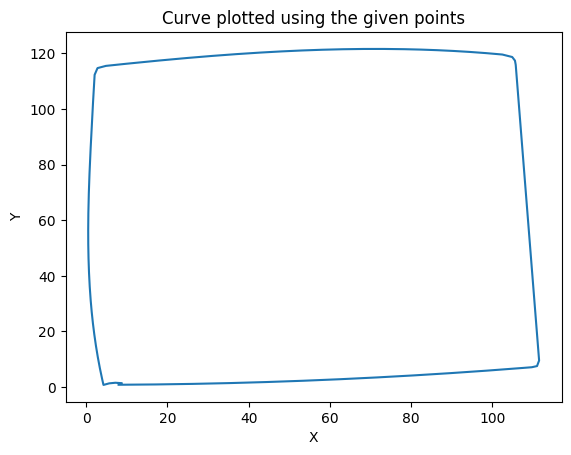

In [71]:
import numpy as np
import matplotlib.pyplot as plt

x, y = [], []
for path_XY in paths:
    for XY in path_XY:
        x.append(XY[:, 0])
        y.append(XY[:, 1])

x = np.array(x[2])
y = np.array(y[2])


plt.plot(x, y)
plt.title("Curve plotted using the given points")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

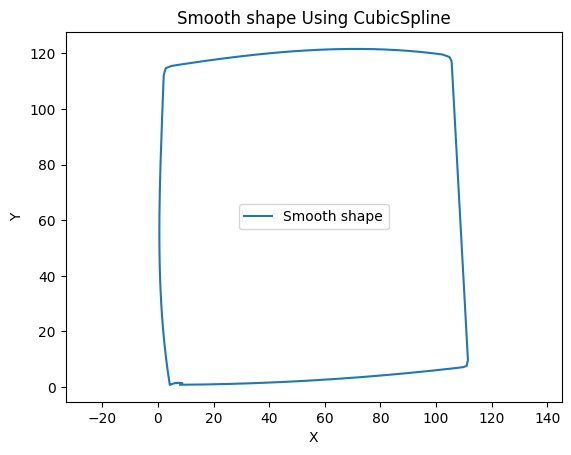

In [156]:
import numpy as np
# from scipy.interpolate import CubicSpline
import bezier
import matplotlib.pyplot as plt

# Generate points on a circle
# if x[0] != x[-1] or y[0] != y[-1]:
#     x = np.append(x, x[0])
#     y = np.append(y, y[0])
nodes = np.asfortranarray([x, y])

# Create a Bézier curve from the nodes
curves = []
for i in range(len(x) - 1):
    segment_nodes = nodes[:, i:i+2]
    curve = bezier.Curve(segment_nodes, degree=1)
    curves.append(curve)


# Evaluate the curve at num_points equally spaced intervals
s_vals = np.linspace(0.0, 1.0, 500)
points = curve.evaluate_multi(s_vals)

x_new = np.array([])
y_new = np.array([])
for curve in curves:
    points = curve.evaluate_multi(s_vals)
    x_new = np.append(x_new, points[0, :])
    y_new = np.append(y_new, points[1, :])

# Plot the original points and the interpolated smooth curve
plt.plot(x_new, y_new, label=f'Smooth shape')
# plt.scatter(x, y, color='red', label=f'Original shape Points')
plt.title(f"Smooth shape Using CubicSpline")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.legend()
plt.show()


C:\Users\Disha Shah\AppData\Local\Temp\ipykernel_10620\780137470.py:186: RuntimeWarning: invalid value encountered in divide
  t_hat_center /= np.linalg.norm(t_hat_center)


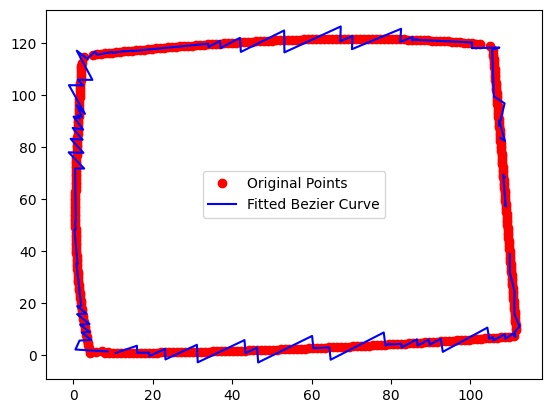

In [74]:
import numpy as np
import matplotlib.pyplot as plt

class FitCurves:
    @staticmethod
    def bezier_ii(degree, V, t):
        Vtemp = np.copy(V)
        for i in range(1, degree + 1):
            for j in range(degree - i + 1):
                Vtemp[j] = (1.0 - t) * Vtemp[j] + t * Vtemp[j + 1]
        return Vtemp[0]

    @staticmethod
    def newton_raphson_root_find(Q, P, u):
        Q = np.array(Q)  # Ensure Q is a NumPy array
        P = np.array(P)  # Ensure P is a NumPy array
        
        Q_u = FitCurves.bezier_ii(3, Q, u)
        Q1 = 3 * (Q[1:] - Q[:-1])
        Q2 = 2 * (Q1[1:] - Q1[:-1])
        Q1_u = FitCurves.bezier_ii(2, Q1, u)
        Q2_u = FitCurves.bezier_ii(1, Q2, u)

        numerator = np.dot(Q_u - P, Q1_u)
        denominator = np.dot(Q1_u, Q1_u) + np.dot(Q_u - P, Q2_u)

        if denominator == 0:
            return u

        return u - numerator / denominator

    @staticmethod
    def fit_curve(points, error):
        t_hat1 = FitCurves.compute_left_tangent(points, 0)
        t_hat2 = FitCurves.compute_right_tangent(points, len(points) - 1)
        result = []
        FitCurves.fit_cubic(points, 0, len(points) - 1, t_hat1, t_hat2, error, result)
        return np.array(result)

    @staticmethod
    def fit_cubic(points, first, last, t_hat1, t_hat2, error, result):
        iteration_error = error * error
        n_pts = last - first + 1

        if n_pts == 2:
            dist = np.linalg.norm(points[first] - points[last]) / 3.0
            bez_curve = [
                points[first],
                points[first] + t_hat1 * dist,
                points[last] + t_hat2 * dist,
                points[last],
            ]
            result.extend(bez_curve[1:])
            return

        u = FitCurves.chord_length_parameterize(points, first, last)
        bez_curve = FitCurves.generate_bezier(points, first, last, u, t_hat1, t_hat2)
        max_error, split_point = FitCurves.compute_max_error(
            points, first, last, bez_curve, u
        )

        if max_error < error:
            result.extend(bez_curve[1:])
            return

        if max_error < iteration_error:
            for i in range(4):
                u_prime = FitCurves.reparameterize(points, first, last, u, bez_curve)
                bez_curve = FitCurves.generate_bezier(
                    points, first, last, u_prime, t_hat1, t_hat2
                )
                max_error, split_point = FitCurves.compute_max_error(
                    points, first, last, bez_curve, u_prime
                )
                if max_error < error:
                    result.extend(bez_curve[1:])
                    return
                u = u_prime

        t_hat_center = FitCurves.compute_center_tangent(points, split_point)
        FitCurves.fit_cubic(
            points, first, split_point, t_hat1, t_hat_center, error, result
        )
        FitCurves.fit_cubic(
            points, split_point, last, -t_hat_center, t_hat2, error, result
        )

    @staticmethod
    def generate_bezier(points, first, last, u_prime, t_hat1, t_hat2):
        n_pts = last - first + 1
        A = np.zeros((n_pts, 2, 2))
        C = np.zeros((2, 2))
        X = np.zeros(2)

        for i in range(n_pts):
            A[i, 0] = t_hat1 * FitCurves.B1(u_prime[i])
            A[i, 1] = t_hat2 * FitCurves.B2(u_prime[i])

        for i in range(n_pts):
            C[0, 0] += np.dot(A[i, 0], A[i, 0])
            C[0, 1] += np.dot(A[i, 0], A[i, 1])
            C[1, 1] += np.dot(A[i, 1], A[i, 1])
            tmp = points[first + i] - (
                points[first] * FitCurves.B0(u_prime[i])
                + points[first] * FitCurves.B1(u_prime[i])
                + points[last] * FitCurves.B2(u_prime[i])
                + points[last] * FitCurves.B3(u_prime[i])
            )
            X[0] += np.dot(A[i, 0], tmp)
            X[1] += np.dot(A[i, 1], tmp)

        C[1, 0] = C[0, 1]

        det_C0_C1 = C[0, 0] * C[1, 1] - C[1, 0] * C[0, 1]
        det_C0_X = C[0, 0] * X[1] - C[1, 0] * X[0]
        det_X_C1 = X[0] * C[1, 1] - X[1] * C[0, 1]

        alpha_l = 0.0 if det_C0_C1 == 0 else det_X_C1 / det_C0_C1
        alpha_r = 0.0 if det_C0_C1 == 0 else det_C0_X / det_C0_C1

        seg_length = np.linalg.norm(points[first] - points[last])
        epsilon = 1.0e-6 * seg_length

        if alpha_l < epsilon or alpha_r < epsilon:
            dist = seg_length / 3.0
            bez_curve = [
                points[first],
                points[first] + t_hat1 * dist,
                points[last] + t_hat2 * dist,
                points[last],
            ]
            return bez_curve

        bez_curve = [
            points[first],
            points[first] + t_hat1 * alpha_l,
            points[last] + t_hat2 * alpha_r,
            points[last],
        ]
        return bez_curve

    @staticmethod
    def reparameterize(points, first, last, u, bez_curve):
        n_pts = last - first + 1
        u_prime = np.zeros(n_pts)

        for i in range(n_pts):
            u_prime[i] = FitCurves.newton_raphson_root_find(
                bez_curve, points[first + i], u[i]
            )

        return u_prime

    @staticmethod
    def compute_max_error(points, first, last, bez_curve, u):
        max_dist = 0.0
        split_point = (last - first + 1) // 2

        for i in range(first + 1, last):
            P = FitCurves.bezier_ii(3, bez_curve, u[i - first])
            dist = np.linalg.norm(P - points[i]) ** 2
            if dist >= max_dist:
                max_dist = dist
                split_point = i

        return max_dist, split_point

    @staticmethod
    def compute_left_tangent(points, end):
        t_hat1 = points[end + 1].astype(float) - points[end].astype(float)
        t_hat1 /= np.linalg.norm(t_hat1)
        return t_hat1

    @staticmethod
    def compute_right_tangent(points, end):
        t_hat2 = points[end - 1].astype(float) - points[end].astype(float)
        t_hat2 /= np.linalg.norm(t_hat2)
        return t_hat2


    @staticmethod
    def compute_center_tangent(points, center):
        V1 = points[center - 1] - points[center]
        V2 = points[center + 1] - points[center]
        t_hat_center = V1 + V2
        t_hat_center /= np.linalg.norm(t_hat_center)
        return t_hat_center

    @staticmethod
    def chord_length_parameterize(points, first, last):
        u = np.zeros(last - first + 1)
        for i in range(1, last - first + 1):
            u[i] = u[i - 1] + np.linalg.norm(points[first + i] - points[first + i - 1])
        u /= u[-1]
        return u

    @staticmethod
    def B0(u):
        return (1.0 - u) ** 3

    @staticmethod
    def B1(u):
        return 3 * u * (1.0 - u) ** 2

    @staticmethod
    def B2(u):
        return 3 * u ** 2 * (1.0 - u)

    @staticmethod
    def B3(u):
        return u ** 3

# x = np.array([0, 1, 2, 3, 4])
# y = np.array([0, 1, 4, 1, 0])
points = np.column_stack((x, y))

error = 4.0
result = FitCurves.fit_curve(points, error)
result = np.array(result)

plt.plot(x, y, 'ro', label='Original Points')
plt.plot(result[:, 0], result[:, 1], 'b-', label='Fitted Bezier Curve')
plt.legend()
plt.show()



2024-08-08 13:10:52,861 - DEBUG - Points: [[  7.98000002   0.83999997]
 [  8.98950958   0.84788334]
 [  9.99900818   0.85685998]
 [ 11.00849438   0.86692989]
 [ 12.01796722   0.878093  ]
 [ 13.02742577   0.89034915]
 [ 14.0368681    0.90369827]
 [ 15.04629326   0.91814029]
 [ 16.05570221   0.93367511]
 [ 17.06509018   0.95030266]
 [ 18.07445908   0.96802288]
 [ 19.08380508   0.98683566]
 [ 20.09313011   1.00674081]
 [ 21.10243034   1.02773845]
 [ 22.11170578   1.04982829]
 [ 23.12095642   1.07301033]
 [ 24.13017845   1.09728456]
 [ 25.13937378   1.12265074]
 [ 26.14853859   1.14910889]
 [ 27.15767288   1.17665887]
 [ 28.16677475   1.20530069]
 [ 29.1758461    1.23503411]
 [ 30.18488121   1.26585913]
 [ 31.19388199   1.29777563]
 [ 32.20284653   1.33078349]
 [ 33.21177292   1.36488283]
 [ 34.22066116   1.40007329]
 [ 35.22951126   1.43635499]
 [ 36.2383194    1.4737277 ]
 [ 37.24708557   1.5121913 ]
 [ 38.25580978   1.55174589]
 [ 39.26448822   1.59239125]
 [ 40.27312088   1.63412738]
 

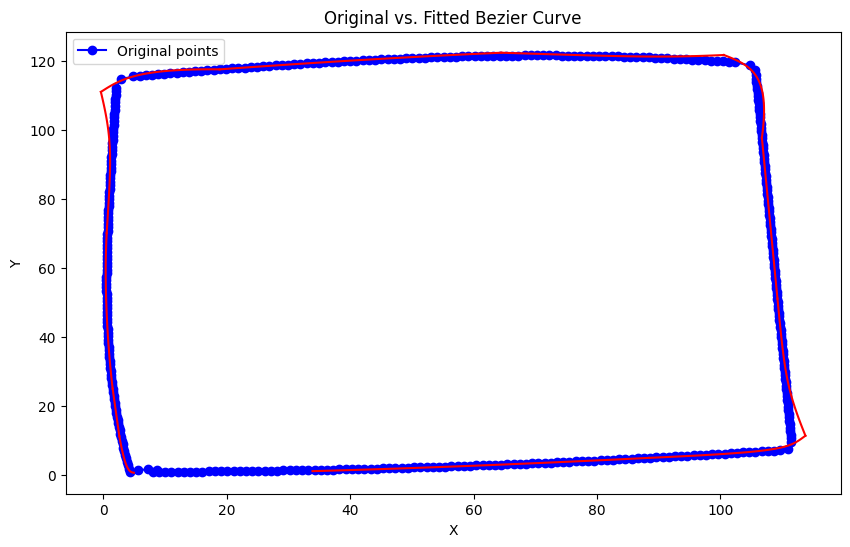

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Class for fitting curves
class FitCurves:
    MAXPOINTS = 10000

    @staticmethod
    def fit_curve(points, error):
        points = np.array(points)  # Ensure points are numpy array
        logging.debug(f'Points: {points}')
        t_hat1 = FitCurves.compute_left_tangent(points, 0)
        t_hat2 = FitCurves.compute_right_tangent(points, len(points) - 1)
        result = []
        FitCurves.fit_cubic(points, 0, len(points) - 1, t_hat1, t_hat2, error, result)
        logging.debug(f'Fitted result: {result}')
        return result

    @staticmethod
    def fit_cubic(points, first, last, t_hat1, t_hat2, error, result):
        iteration_error = error * error
        n_pts = last - first + 1
        logging.debug(f'Fitting cubic: first={first}, last={last}, n_pts={n_pts}')

        if n_pts == 2:
            dist = np.linalg.norm(points[first] - points[last]) / 3.0
            bez_curve = [
                points[first],
                points[first] + t_hat1 * dist,
                points[last] + t_hat2 * dist,
                points[last],
            ]
            result.extend(bez_curve[1:])
            return

        u = FitCurves.chord_length_parameterize(points, first, last)
        bez_curve = FitCurves.generate_bezier(points, first, last, u, t_hat1, t_hat2)
        max_error, split_point = FitCurves.compute_max_error(
            points, first, last, bez_curve, u
        )
        logging.debug(f'Max error: {max_error}, Split point: {split_point}')

        if max_error < error:
            result.extend(bez_curve[1:])
            return

        if max_error < iteration_error:
            for i in range(4):
                u_prime = FitCurves.reparameterize(points, first, last, u, bez_curve)
                bez_curve = FitCurves.generate_bezier(
                    points, first, last, u_prime, t_hat1, t_hat2
                )
                max_error, split_point = FitCurves.compute_max_error(
                    points, first, last, bez_curve, u_prime
                )
                logging.debug(f'Iteration {i}: Max error: {max_error}, Split point: {split_point}')
                if max_error < error:
                    result.extend(bez_curve[1:])
                    return
                u = u_prime

        t_hat_center = FitCurves.compute_center_tangent(points, split_point)
        FitCurves.fit_cubic(
            points, first, split_point, t_hat1, t_hat_center, error, result
        )
        FitCurves.fit_cubic(
            points, split_point, last, -t_hat_center, t_hat2, error, result
        )

    @staticmethod
    def generate_bezier(points, first, last, u_prime, t_hat1, t_hat2):
        n_pts = last - first + 1
        A = np.zeros((n_pts, 2, 2))
        C = np.zeros((2, 2))
        X = np.zeros(2)

        for i in range(n_pts):
            A[i, 0] = t_hat1 * FitCurves.B1(u_prime[i])
            A[i, 1] = t_hat2 * FitCurves.B2(u_prime[i])

        for i in range(n_pts):
            C[0, 0] += np.dot(A[i, 0], A[i, 0])
            C[0, 1] += np.dot(A[i, 0], A[i, 1])
            C[1, 1] += np.dot(A[i, 1], A[i, 1])
            tmp = points[first + i] - (
                points[first] * FitCurves.B0(u_prime[i])
                + points[first] * FitCurves.B1(u_prime[i])
                + points[last] * FitCurves.B2(u_prime[i])
                + points[last] * FitCurves.B3(u_prime[i])
            )
            X[0] += np.dot(A[i, 0], tmp)
            X[1] += np.dot(A[i, 1], tmp)

        C[1, 0] = C[0, 1]

        det_C0_C1 = C[0, 0] * C[1, 1] - C[1, 0] * C[0, 1]
        det_C0_X = C[0, 0] * X[1] - C[1, 0] * X[0]
        det_X_C1 = X[0] * C[1, 1] - X[1] * C[0, 1]

        alpha_l = 0.0 if det_C0_C1 == 0 else det_X_C1 / det_C0_C1
        alpha_r = 0.0 if det_C0_C1 == 0 else det_C0_X / det_C0_C1

        seg_length = np.linalg.norm(points[first] - points[last])
        epsilon = 1.0e-6 * seg_length

        if alpha_l < epsilon or alpha_r < epsilon:
            dist = seg_length / 3.0
            bez_curve = [
                points[first],
                points[first] + t_hat1 * dist,
                points[last] + t_hat2 * dist,
                points[last],
            ]
            return bez_curve

        bez_curve = [
            points[first],
            points[first] + t_hat1 * alpha_l,
            points[last] + t_hat2 * alpha_r,
            points[last],
        ]
        return bez_curve

    @staticmethod
    def reparameterize(points, first, last, u, bez_curve):
        n_pts = last - first + 1
        u_prime = np.zeros(n_pts)

        for i in range(n_pts):
            u_prime[i] = FitCurves.newton_raphson_root_find(
                bez_curve, points[first + i], u[i]
            )

        return u_prime

    @staticmethod
    def newton_raphson_root_find(Q, P, u):
        Q = np.array(Q)  # Ensure Q is a NumPy array
        P = np.array(P)  # Ensure P is a NumPy array
        Q_u = FitCurves.bezier_ii(3, Q, u)
        Q1 = 3 * (Q[1:] - Q[:-1])
        Q2 = 2 * (Q1[1:] - Q1[:-1])
        Q1_u = FitCurves.bezier_ii(2, Q1, u)
        Q2_u = FitCurves.bezier_ii(1, Q2, u)

        numerator = np.dot(Q_u - P, Q1_u)
        denominator = np.dot(Q1_u, Q1_u) + np.dot(Q_u - P, Q2_u)

        if denominator == 0:
            return u

        return u - numerator / denominator

    @staticmethod
    def bezier_ii(degree, V, t):
        Vtemp = V.copy()
        for i in range(1, degree + 1):
            for j in range(degree - i + 1):
                Vtemp[j] = (1.0 - t) * Vtemp[j] + t * Vtemp[j + 1]
        return Vtemp[0]

    @staticmethod
    def B0(u):
        return (1.0 - u) ** 3

    @staticmethod
    def B1(u):
        return 3 * u * (1.0 - u) ** 2

    @staticmethod
    def B2(u):
        return 3 * u**2 * (1.0 - u)

    @staticmethod
    def B3(u):
        return u**3

    @staticmethod
    def compute_left_tangent(points, end):
        if end + 1 >= len(points):
            raise ValueError("Not enough points to compute tangent.")
        t_hat1 = np.subtract(points[end + 1], points[end])
        t_hat1 /= np.linalg.norm(t_hat1)
        return t_hat1

    @staticmethod
    def compute_right_tangent(points, end):
        if end - 1 < 0:
            raise ValueError("Not enough points to compute tangent.")
        t_hat2 = np.subtract(points[end - 1], points[end])
        t_hat2 /= np.linalg.norm(t_hat2)
        return t_hat2

    @staticmethod
    def compute_center_tangent(points, center):
        V1 = points[center - 1] - points[center]
        V2 = points[center] - points[center + 1]
        t_hat_center = (V1 + V2) / 2.0
        return t_hat_center / np.linalg.norm(t_hat_center)

    @staticmethod
    def chord_length_parameterize(points, first, last):
        u = np.zeros(last - first + 1)
        u[0] = 0.0
        for i in range(first + 1, last + 1):
            u[i - first] = u[i - first - 1] + np.linalg.norm(points[i] - points[i - 1])
        u /= u[-1]
        return u

    @staticmethod
    def compute_max_error(points, first, last, bez_curve, u):
        max_dist = 0.0
        split_point = (last - first + 1) // 2

        for i in range(first + 1, last):
            P = FitCurves.bezier_ii(3, bez_curve, u[i - first])
            dist = np.linalg.norm(P - points[i]) ** 2
            if dist >= max_dist:
                max_dist = dist
                split_point = i

        return max_dist, split_point

# Sample points from your CSV (assuming they're read into `x` and `y` arrays)
points = np.column_stack((x, y))

# Fit the curve with a specified error tolerance
error = 4.0  # Adjust the error tolerance as needed
fitted_points = FitCurves.fit_curve(points, error)

# Prepare data for plotting Bezier curve segments
def bezier_curve_segment(control_points, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))
    for i in range(num_points):
        curve[i] = FitCurves.bezier_ii(3, control_points, t[i])
    return curve

bezier_curves = []
for i in range(0, len(fitted_points) - 3, 3):
    bezier_curves.append(bezier_curve_segment(fitted_points[i:i + 4]))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(points[:, 0], points[:, 1], 'bo-', label='Original points')
for curve in bezier_curves:
    plt.plot(curve[:, 0], curve[:, 1], 'r-', label='Fitted Bezier curve' if not plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original vs. Fitted Bezier Curve')
plt.show()

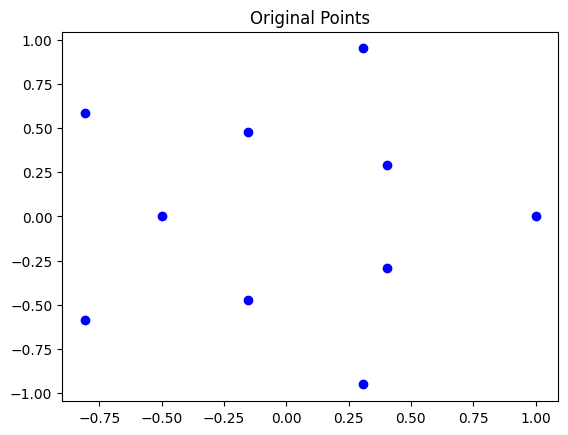

Trying eps=0.5, min_samples=5: Original points: 10, Cleaned points: 0
Trying eps=0.5, min_samples=3: Original points: 10, Cleaned points: 0
Trying eps=0.5, min_samples=1: Original points: 10, Cleaned points: 10


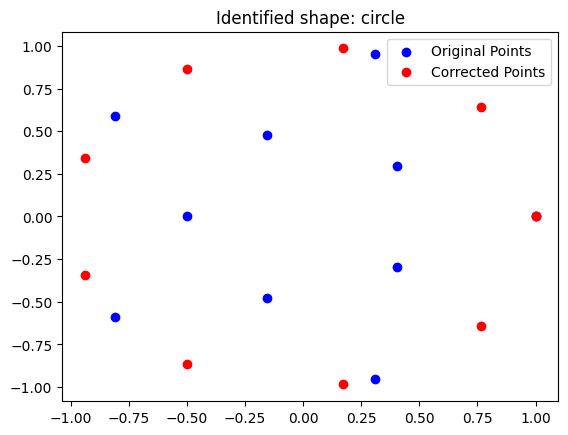

In [73]:
import svgwrite
import cairosvg


def polylines2svg(
    paths_XYs,
    svg_path,
    colours=["yellow"],
):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile="tiny", shape_rendering="crispEdges")
    group = dwg.g()
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            # if not np.allclose(XY[0], XY[-1]):
            #     path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill="none", stroke=c, stroke_width=2))
    dwg.add(group)
    dwg.save()
    png_path = svg_path.replace(".svg", ".png")
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(
        url=svg_path,
        write_to=png_path,
        parent_width=W,
        parent_height=H,
        output_width=fact * W,
        output_height=fact * H,
        background_color="white",
    )
    return


polylines2svg(paths, "test.svg")

In [1]:
import os

os.environ["path"] += r"C:\Program Files\GTK3-Runtime Win64\bin"

In [2]:
import numpy as np
print(np.__version__)

2.0.1


In [3]:
import cv2
print(cv2.__version__)

4.10.0


### import opencv and initialization

In [37]:
import numpy as np
import cv2  # Only for displaying results, not for shape detection

def detect_shapes(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define color thresholds (adjust as needed)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Create masks
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Find contours (connected components)
    contours, _ = cv2.findContours(mask_yellow, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)

        # Calculate area to filter out small contours
        area = cv2.contourArea(cnt)
        if area < 500:  # Adjust threshold as needed
            continue

        if len(approx) == 4:
            shape = "square"
            # Draw a green square border
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        elif len(approx) > 4 and area > 1000:  # Filter out small circles
            shape = "circle"
            # Draw a blue circle border
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(img, center, radius, (255, 0, 0), 2)
        else:
            shape = "unknown"

        # Draw label
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.putText(img, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.namedWindow('Shapes', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Shapes', 600, 600)
    cv2.imshow("Shapes", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
image_path = "test.png"
detect_shapes(image_path)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Disha Shah\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\Disha Shah\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\Disha Shah\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import